In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [3]:
# Read in and combine the 2 playlist
df_h = pd.read_csv('C:/Users/Simon/Documents/projects/MusicLabel/data/h_list.csv')
df_s = pd.read_csv('C:/Users/Simon/Documents/projects/MusicLabel/data/s_list.csv')
df = pd.concat([df_h, df_s], ignore_index=True)
df.drop(['title', 'album', 'sr'], axis=1, inplace=True)

In [4]:
# Some artist only had 1 songs in my list - recode this so all songs with 
artist_to_change = df.loc[df.groupby('artist')['artist'].transform('size') <= 2, 'artist']
df.loc[df['artist'].isin(artist_to_change), 'artist'] = 'Other artists'

In [6]:
agg = df.groupby('label').agg(['mean'])
agg.filter(like='dtempo', axis=1)

,dtempo_mean,dtempo_std,dtempo_p10,dtempo_q1,dtempo_median,dtempo_q3,dtempo_p90,dtempo_maxv,dtempo_iqr,dtempo_skew,dtempo_kurt,dtempo_mode
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
label,,,,,,,,,,,,
0,117.855102,18.434793,102.387756,108.742816,115.654849,123.990870,135.655959,197.083497,15.248055,1.848777,24.113825,115.055556
1,115.336175,15.628960,104.062368,107.172384,112.549793,120.329173,130.211393,189.807060,13.156789,2.704133,35.574409,111.736264


In [7]:
agg.filter(like='ons', axis=1)

,ons_mean,ons_std,ons_p10,ons_q1,ons_median,ons_q3,ons_p90,ons_maxv,ons_iqr,ons_skew,ons_kurt,ons_mode
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
label,,,,,,,,,,,,
0,1.428790,1.515412,0.489169,0.707139,0.988303,1.491931,2.764838,22.002734,0.784792,4.067947,26.182272,1.0
1,1.466776,1.462699,0.520537,0.746186,1.042612,1.571358,2.810969,22.186600,0.825172,3.934873,25.097857,1.0


In [8]:
df.groupby('label')['artist'].value_counts()[lambda x: x >= 5]

label  artist       
0      GorDoN           20
       Soft Lipa        20
       蛋堡 Soft Lipa     17
       Other artists    15
       MC HotDog        10
       Yitai Wang        6
       Leo Wang          5
       MJ116             5
1      Other artists    40
       MJ116            18
       蛋堡 Soft Lipa     15
       MC HotDog        13
       GorDoN           12
       Leo Wang          9
       Yitai Wang        9
       TroutFresh        7
       C-BLOCK           6
       Juzzy Orange      6
       Soft Lipa         5
       Yeemao            5
Name: artist, dtype: int64

In [329]:
# I'd expect tempo to be faster in my High list, and higher onset strength (yes but only slightly)
# Could be the songs are too alike, or it lies in the combination of features to make it sound the way I could put songs into high/slow list

In [5]:
# Train/test split
x = df.loc[:, ~df.columns.isin(['label'])]
y = df.loc[:, 'label'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=363)

In [17]:
# Sep out categorical/numerical and apply preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), make_column_selector(dtype_exclude='object')),
    ('cat', OneHotEncoder(), make_column_selector(dtype_include='object'))])
x_train_pp = preprocessor.fit_transform(x_train)

In [18]:
# Run PCA and use 95% variance explained
pca = PCA(.95)
x_train_pca = pca.fit_transform(x_train_pp)

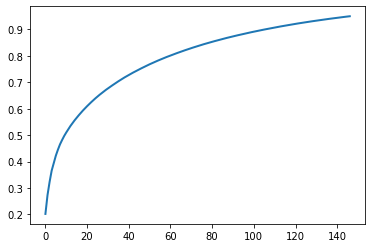

In [19]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
plt.plot(exp_var_cumul,linewidth=2)
plt.show()

In [20]:
len(exp_var_cumul) - len(exp_var_cumul[exp_var_cumul<0.9])

41

In [21]:
x_test_pp = preprocessor.transform(x_test)
x_test_pca = pca.transform(x_test_pp)

In [263]:
# Random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = np.arange(1, 5).tolist()
min_samples_leaf = np.arange(1, 4).tolist()

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, random_state=363, n_jobs = 5)
rf_random.fit(x_train_pca, y_train)
print(rf_random.best_params_)
print('%s %.3f' % ('train acc:', accuracy_score(y_train, rf_random.best_estimator_.predict(x_train_pca))))
print('%s %.3f' % ('test acc:', accuracy_score(y_test, rf_random.best_estimator_.predict(x_test_pca))))

C:\Users\Simon\anaconda3\envs\MusicLabel\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.65469388 0.63020408 0.63428571 0.66277551 0.64644898        nan
 0.65053061 0.63836735 0.61787755 0.62604082 0.63020408 0.64228571
        nan        nan 0.64244898 0.63420408 0.63428571        nan
        nan 0.65461224 0.63428571 0.65053061 0.64644898 0.63020408
        nan        nan 0.63020408        nan 0.64228571 0.64236735
        nan        nan 0.63436735 0.65053061 0.63420408 0.63028571
 0.64236735 0.64653061 0.63836735        nan 0.64244898 0.63436735
 0.64620408 0.63836735 0.65461224 0.64661224 0.64244898        nan
 0.62212245 0.63020408 0.64228571 0.64253061 0.65053061 0.63428571
        nan        nan 0.60579592 0.65044898 0.65053061 0.66285714
 0.65053061 0.64644898 0.63828571 0.63844898 0.65053061 0.63036735
 0.63395918 0.63836735 0.63453061 0.65444898 0.63012245 0.65877551
 0.63828571 0.63428571 0.64244898 0.6

{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 90}


In [286]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 8)]
max_depth = [int(x) for x in np.linspace(30, 100, num = 8)]
min_samples_split = np.arange(1, 3).tolist()
min_samples_leaf = np.arange(1, 3).tolist()

grid = {'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf}

rf_grid = GridSearchCV(estimator = rf, param_grid = grid, n_jobs = 5, cv = 5, scoring='accuracy')
rf_grid.fit(x_train_pca, y_train)
print(rf_grid.best_params_)
print('%s %.3f' % ('test acc:', accuracy_score(y_test, rf_grid.best_estimator_.predict(x_test_pca))))

C:\Users\Simon\anaconda3\envs\MusicLabel\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan -0.65521172 -0.65022891 -0.65027338 -0.65052315
 -0.65220256 -0.65289094 -0.6452811  -0.65128911         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.65168095 -0.64464018 -0.64487027 -0.64379562 -0.64648139 -0.64513545
 -0.64267947 -0.64402713         nan         nan         nan         nan
         nan         nan         nan         nan -0.65419833 -0.65888157
 -0.65716261 -0.64752069 -0.65113488 -0.64455455 -0.64767216 -0.65177104
         nan         nan         nan         nan         nan         nan
         nan         nan -0.64686592 -0.64705049 -0.64332243 -0.65089665
 -0.64660786 -0.64329662 -0.64452324 -0.64449447         nan         nan
         nan         nan         nan  

{'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


The final 5% of variance explained needed 41 components - considered use 90% in testing. 

In performance, 90% PCA wasn't better (repetitve code omitted). Accuracy (64.5%) is not adequate.

In [ ]:
# Try xgboost instead
parameters = {"eta": [0.10, 0.20, 0.3],
              "max_depth": [2, 4, 6],
              "min_child_weight": [1, 2, 3],
              "gamma": [0, 0.1, 0.2, 0.3],
              "subsample": [0.5, 1],
              "objective": ['binary:logistic', 'rank:map']}

boost = xgb.XGBClassifier(use_label_encoder=False)
xgb_grid = GridSearchCV(boost, 
                        parameters, 
                        cv = 5, n_jobs = 5, scoring = "accuracy")

xgb_grid.fit(x_train_pca, y_train)
cv = cross_val_score(xgb_grid, x_train_pca, y_train, cv=5, scoring='accuracy')
print(xgb_grid.best_params_)
print('%s %.3f' % ('train cv acc:', cv.mean()))
print('%s %.3f' % ('test acc:', accuracy_score(y_test, xgb_grid.best_estimator_.predict(x_test_pca))))

In [178]:
# Both method looks like overfitting - try with mean mfcc only and/or less components
x_mfcc = df.filter(like='mfcc_mean')
y = df.loc[:, 'label'].values
x_mfcc_train, x_mfcc_test, y_train, y_test = train_test_split(x_mfcc, y, test_size=0.2, random_state=363)

In [179]:
x_mfcc_train_pp = preprocessor.fit_transform(x_mfcc_train)
x_mfcc_test_pp = preprocessor.transform(x_mfcc_test)

In [ ]:
parameters = {"eta": [0.02, 0.05, 0.10, 0.15, 0.20, 0.25],
              "max_depth": [1, 2, 3, 4],
              "min_child_weight": [1, 2, 3, 4],
              "gamma": [0.1, 0.2, 0.3, 0.4, 0.5],
              "colsample_bytree": [0.2, 0.3, 0.4, 0.5],
              "subsample": [0.5, 0.75, 1]}

boost = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic')
xgb_grid = GridSearchCV(boost, 
                        parameters, 
                        cv = 5, n_jobs = 5, scoring = "accuracy")

xgb_grid.fit(x_mfcc_train_pp, y_train)
cv = cross_val_score(xgb_grid, x_mfcc_train_pp, y_train, cv=5, scoring='accuracy')
print(xgb_grid.best_params_)
print('%s %.3f' % ('train cv acc:', cv.mean()))
print('%s %.3f' % ('test acc:', accuracy_score(y_test, xgb_grid.best_estimator_.predict(x_mfcc_test))))

In [ ]:
# Try with max MFCC
x_mfcc_max = df.filter(like='mfcc_max')
y = df.loc[:, 'label'].values
x_mfcc_max_train, x_mfcc_max_test, y_train, y_test = train_test_split(x_mfcc_max, y, test_size=0.2, random_state=363)
x_mfcc_max_train_pp = preprocessor.fit_transform(x_mfcc_max_train)
x_mfcc_max_test_pp = preprocessor.transform(x_mfcc_max_test)
parameters = {"eta": [0.20, 0.25, 0.3, 0.35],
              "max_depth": [2, 4, 6],
              "min_child_weight": [1, 2, 3],
              "gamma": [0, 0.1, 0.2, 0.3],
              "subsample": [0.5, 1],
              "n_estimators": [50, 100, 150]}

boost = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic')
xgb_grid = GridSearchCV(boost, 
                        parameters, 
                        cv = 5, n_jobs = 5, scoring = "accuracy")

xgb_grid.fit(x_mfcc_max_train_pp, y_train)
cv = cross_val_score(xgb_grid, x_mfcc_max_train_pp, y_train, cv=5, scoring='accuracy')
print(xgb_grid.best_params_)
print('%s %.3f' % ('train cv acc:', cv.mean()))
print('%s %.3f' % ('test acc:', accuracy_score(y_test, xgb_grid.best_estimator_.predict(x_mfcc_max_test_pp))))

In [360]:
# Try with less compoenents

In [28]:
def subset_pca(n_pca_list):
    for n_pca in n_pca_list:        
        x_train_pca_subset = x_train_pca[:,0:n_pca]
        x_test_pca_subset = x_test_pca[:,0:n_pca]

        boost = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')
        boost.fit(x_train_pca_subset, y_train)
        cv = cross_val_score(boost, x_train_pca_subset, y_train, cv=5, scoring='accuracy')
        print(str(n_pca) + ' compoenents')
        print('%s %.3f' % ('train cv acc:', cv.mean()))
        print('%s %.3f' % ('test acc:', accuracy_score(y_test, boost.predict(x_test_pca_subset))))
    pass

In [29]:
l = [int(x) for x in np.linspace(10, 100, num = 10)]
subset_pca(l)

10 compoenents
train cv acc: 0.707
test acc: 0.645
20 compoenents
train cv acc: 0.720
test acc: 0.661
30 compoenents
train cv acc: 0.675
test acc: 0.710
40 compoenents
train cv acc: 0.691
test acc: 0.710
50 compoenents
train cv acc: 0.711
test acc: 0.726
60 compoenents
train cv acc: 0.683
test acc: 0.661
70 compoenents
train cv acc: 0.687
test acc: 0.645
80 compoenents
train cv acc: 0.707
test acc: 0.661
90 compoenents
train cv acc: 0.691
test acc: 0.661
100 compoenents
train cv acc: 0.687
test acc: 0.645


In [32]:
parameters = {"eta": [0.20, 0.25, 0.3, 0.35],
              "max_depth": [2, 4, 6],
              "min_child_weight": [1, 2, 3],
              "gamma": [0, 0.1, 0.2, 0.3],
              "subsample": [0.5, 1],
              "n_estimators": [50, 100, 150]}

boost = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')
xgb_grid = GridSearchCV(boost, 
                        parameters, 
                        cv = 5, n_jobs = 5, scoring = "accuracy")

# from above, using the default, 50 compoenets worked best
# use 50 and tune other hyperparameter
x_train_pca_subset = x_train_pca[:,0:50]
x_test_pca_subset = x_test_pca[:,0:50]
xgb_grid.fit(x_train_pca_subset, y_train)
print(xgb_grid.best_params_)
print('%s %.3f' % ('train acc:', accuracy_score(y_train, xgb_grid.best_estimator_.predict(x_train_pca_subset))))
print('%s %.3f' % ('test acc:', accuracy_score(y_test, xgb_grid.best_estimator_.predict(x_test_pca_subset))))

{'eta': 0.3, 'gamma': 0.2, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 1}
train acc: 0.988
test acc: 0.694


In [174]:
# Some improvement by using MFCC (mean) only or less components, but unlikely I can improve a lot (say to 80%+)
# further just by tweaking small things/subset features.
# Try simple NN instead - make sense given how many interactions is there between all these musical features.
import keras as k
from keras.regularizers import l2

model = k.models.Sequential([
    k.layers.Dense(16, activation='relu', input_shape=(x_train_pca.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(16, activation='relu'),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [175]:
batch_size = 32
epochs = 100
history = model.fit(x_train_pca, y_train, batch_size=batch_size, 
                    validation_split=0.2, epochs=epochs, verbose=1, use_multiprocessing=True)

test_loss, test_acc = history.model.evaluate(x_test_pca, y_test)
print('%s %.3f' % ("Test Accuracy Score ", test_acc))

Epoch 1/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1042 - accuracy: 0.4439 - val_loss: 0.9179 - val_accuracy: 0.4800
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 1.0293 - accuracy: 0.4388 - val_loss: 0.8876 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8738 - accuracy: 0.5459 - val_loss: 0.8609 - val_accuracy: 0.5200
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.8517 - accuracy: 0.5204 - val_loss: 0.8389 - val_accuracy: 0.5000
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.7970 - accuracy: 0.5918 - val_loss: 0.8266 - val_accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.7569 - accuracy: 0.5816 - val_loss: 0.8146 - val_accuracy: 0.5200
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.7441 - accuracy: 0.5561 - val_loss: 0.8040 - val_accuracy: 0.5400
Epoch 8/100
7/7 [=========

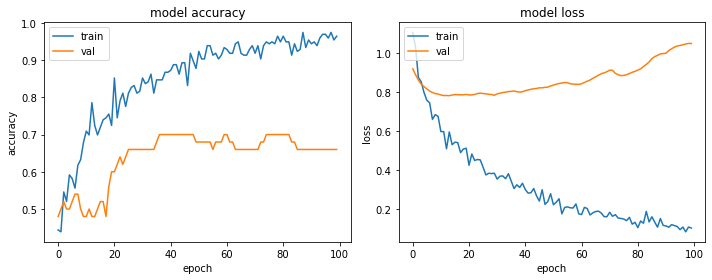

In [176]:
plt.figure(figsize=(10, 4))

# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

In [190]:
model = k.models.Sequential([
    k.layers.Dense(16, activation='relu', input_shape=(x_mfcc_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(16, activation='relu'),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [191]:
batch_size = 32
epochs = 200
history = model.fit(x_mfcc_train, y_train, batch_size=batch_size, 
                    validation_split=0.2, epochs=epochs, verbose=1, use_multiprocessing=True)

test_loss, test_acc = history.model.evaluate(x_mfcc_test, y_test)
print('%s %.3f' % ("Test Accuracy Score ", test_acc))

Epoch 1/200
7/7 [==============================] - 0s 24ms/step - loss: 5.3257 - accuracy: 0.5561 - val_loss: 1.8335 - val_accuracy: 0.6200
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 3.8191 - accuracy: 0.5765 - val_loss: 1.0594 - val_accuracy: 0.6400
Epoch 3/200
7/7 [==============================] - 0s 3ms/step - loss: 3.0024 - accuracy: 0.5765 - val_loss: 1.0773 - val_accuracy: 0.6800
Epoch 4/200
7/7 [==============================] - 0s 4ms/step - loss: 3.1169 - accuracy: 0.5255 - val_loss: 1.0484 - val_accuracy: 0.6400
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 2.5635 - accuracy: 0.5867 - val_loss: 0.9423 - val_accuracy: 0.6400
Epoch 6/200
7/7 [==============================] - 0s 3ms/step - loss: 1.8759 - accuracy: 0.6071 - val_loss: 0.9017 - val_accuracy: 0.6000
Epoch 7/200
7/7 [==============================] - 0s 4ms/step - loss: 2.5493 - accuracy: 0.5612 - val_loss: 0.8663 - val_accuracy: 0.5800
Epoch 8/200
7/7 [=========

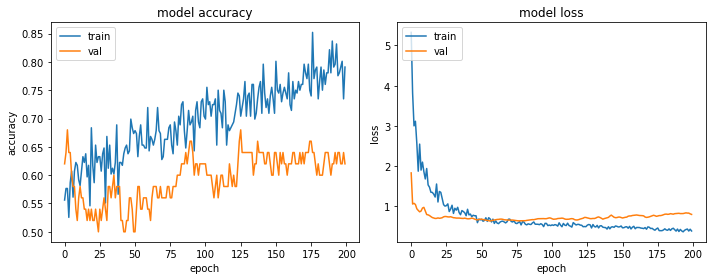

In [192]:
plt.figure(figsize=(10, 4))

# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# I played around with different number of hidden layers, nodes..etc.
# all simliar performace anyway - need an alternative approach